## 変分量子アルゴリズム

まず、VQEの元になっている**変分量子アルゴリズム**（*Variational Quantum Algorithm*, VQA）と呼ばれる手法について見ていきます。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.providers.ibmq import least_busy, IBMQAccountCredentialsNotFound
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import QuantumInstance
from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.gradients import Gradient
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import CG, GradientDescent

# ワークブック独自のモジュール
import sys
sys.path.append('/home/jovyan/qc-workbook-lecturenotes/ja')
from qc_workbook.utils import operational_backend

In [2]:
from qc_workbook.vqe import make_vqe_circuit

n = 3   # 量子ビット数
nl = 2  # レイヤー数
npar = n*2*nl   # パラメータ数

IBMQ.load_account()
try:
    provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='qc-training22')
except IBMQProviderError:
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_list = provider.backends(filters=operational_backend(min_qubits=n))
backend = least_busy(backend_list)

vqe_circuit = make_vqe_circuit(n,nl,npar)

obs = Z ^ X ^ Y

grad = Gradient(grad_method="param_shift")
cg = CG(maxiter=200)
gd = GradientDescent(maxiter=200)
cobyla = COBYLA(maxiter=300)

random_seed = 10598
quantum_instance = QuantumInstance(backend=backend,
                                   shots=8192,
                                   seed_simulator=random_seed,
                                   seed_transpiler=random_seed,
                                   optimization_level=3,
                                   skip_qobj_validation=True)
# VQEアルゴリズムの実装
ibmq_vqe_gfree = VQE(ansatz=vqe_circuit, optimizer=cobyla, quantum_instance=quantum_instance)
result_ibmq_vqe_gfree = ibmq_vqe_gfree.compute_minimum_eigenvalue(obs)

ibmq_vqe_cg = VQE(ansatz=vqe_circuit, optimizer=cg, gradient=grad, quantum_instance=quantum_instance)
result_ibmq_vqe_cg = ibmq_vqe_cg.compute_minimum_eigenvalue(obs)

ibmq_vqe_gd = VQE(ansatz=vqe_circuit, optimizer=gd, gradient=grad, quantum_instance=quantum_instance)
result_ibmq_vqe_gd = ibmq_vqe_gd.compute_minimum_eigenvalue(obs)

/opt/anaconda3/envs/env_qiskit_fy2022_code/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:743: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)
/opt/anaconda3/envs/env_qiskit_fy2022_code/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:743: UserWarning: seed_simulator is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
# 厳密解
ee = NumPyMinimumEigensolver()
result_ee = ee.compute_minimum_eigenvalue(obs)

print('Result:')
print(f'  Exact      = {result_ee.eigenvalue}')
print(f'  VQE(GFree) = {result_ibmq_vqe_gfree.optimal_value}')
print(f'  VQE(CG)    = {result_ibmq_vqe_cg.optimal_value}')
print(f'  VQE(GD)    = {result_ibmq_vqe_gd.optimal_value}')

### 変分フォームを使った実例
ではここで、単一量子ビットの変分フォームを利用してパラメータ最適化の例を実行してみましょう。例として、ランダムな確率分布のベクトル$\vec{x}$（要素数は2）を入力として与えた時、出力の確率分布が$\vec{x}$に近くなるように単一量子ビットの変分フォームを決定するという問題を考えます（2つの確率分布の近さはL1距離によって定義します）。

In [2]:
nq = 1  # 量子ビットの数

npar = 3*nq  # パラメータの数

np.random.seed(999999)
target_distr = np.random.rand(2**nq)
target_distr /= sum(target_distr)

次に、単一の$U3$変分フォームの3つのパラメータを引数として受け取り、対応する量子回路を返す関数を定義します。

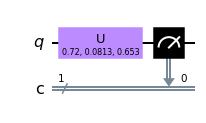

In [3]:
def get_var_form(params):
    qr = QuantumRegister(nq, name="q")
    cr = ClassicalRegister(nq, name='c')
    qc = QuantumCircuit(qr, cr)

    for i in range(nq):
        qc.u(params[3*i], params[3*i+1], params[3*i+2], qr[i])

    for i in range(nq):
        qc.measure(qr[i], cr[i])
    return qc

get_var_form(np.random.rand(npar)).draw('mpl')

変分フォームのパラメータのリストを入力とし、パラメータに対応したコストを計算する目的関数を定義します。アルゴリズムを実行するバックエンドとして、**QASMシミュレータ**を使用します。

In [4]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000  # 測定する回数

# 出力されるビット列の確率分布を計算
def get_probability_distribution(counts):
    output_distr = []
    for i in range(2**nq):
        match = False
        for (k,v) in counts.items():
            if i == int(k,2):
                output_distr.append(v/NUM_SHOTS)
                match = True
        if not match:
            output_distr.append(0)

    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

# コストを計算する目的関数を定義
def objective_function(params):
    qc = get_var_form(params)
    qc = transpile(qc, backend=backend)
    result = backend.run(qc, shots=NUM_SHOTS).result()
    output_distr = get_probability_distribution(result.get_counts(qc))
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2**nq)])
    return cost

最後にCOBYLAオプティマイザーのインスタンスを作成し、アルゴリズムを実行します。出力される確率分布は実行の度に異なり、ターゲットの確率分布と完全には同じにならないことに注意してください。出力の精度は量子計算の回数（ショット数＝NUM_SHOTS）に依存するので、ショット数を増減させた時の一致具合を確認してみてください。

In [5]:
optimizer = COBYLA(maxiter=500, tol=0.0001)

params = np.random.rand(npar)
ret = optimizer.optimize(num_vars=npar, objective_function=objective_function, initial_point=params)

qc = get_var_form(ret[0])
qc = transpile(qc, backend=backend)
counts = backend.run(qc, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:         ", np.round(target_distr,4))
print("Obtained Distribution:       ", np.round(np.array(output_distr),4))
print("Cost Value (L1-Distance):     {:.6f}".format(ret[1]))
print("Parameters Found:            ", np.round(ret[0],4))

Target Distribution:          [0.5136 0.4864]
Obtained Distribution:        [0.5198 0.4802]
Cost Value (L1-Distance):     0.016860
Parameters Found:             [1.5405 0.2643 1.8482]


では次に、この問題を2量子ビット（確率分布の要素数は4）に拡張してやってみましょう。上に戻って

In [ ]:
nq = 2  # 量子ビットの数

として再度実行するとどういう結果が得られるでしょうか。量子回路とオプティマイザーの関係はこのようになってますね。

```{image} figs/vqe_2q_u3.png
:alt: vqe_2q_u3
:class: bg-primary mb-1
:width: 500px
:align: center
```

やってみると分かりますが、結果は1量子ビットの場合と比べて良くないですね。どうすれば良くなるでしょうか？（やり方は複数あると思います）

**一つの解決策：変分フォームにエンタングルメントを導入する**

```python
    for i in range(nq):
        qc.u(params[3*i], params[3*i+1], params[3*i+2], qr[i])
    qc.cx(qr[0],qr[1])
```

どうなるか確かめてください。

量子ビットをエンタングルさせることで相関のあるデータを表現しやすくなるという状況は、例えば、ベル状態（[CHSH不等式の破れを確認する](https://utokyo-icepp.github.io/qc-workbook/chsh_inequality.html#id14)を参照）の確率分布を再現したいときにクリアに見ることができます。上で

In [ ]:
target_distr = np.random.rand(2**nq)

を

In [ ]:
# 00と11を測定する確率が50%、01と10の確率は0
target_distr = np.array([0.5,0.,0.,0.5])

として実行するとどうなるでしょうか。エンタングルさせる場合とさせない場合で大きな違いが見えるでしょう。3量子ビットのGHZ状態（[単純な量子回路をゼロから書く](https://utokyo-icepp.github.io/qc-workbook/circuit_from_scratch.html#ghz)を参照）

In [ ]:
# 000と111を測定する確率が50%、それ以外の確率は0
target_distr = np.array([0.5,0.,0.,0.,0.,0.,0.,0.5])

に拡張してみるなどして、遊んでみてください。

## 変分量子固有値ソルバー法

それでは、ここからVQEの簡単な実装例を見ていくことにします。

### VQEの実装
では、パラメータシフト法を使って簡単なVQEの例を実装してみます。ある観測量の期待値が最小になるように、VQEを使ってAnsatzを更新する回路パラメータを決定するという問題を考えてみます。

量子回路として、$R_YR_Z$ゲートを繰り返すシンプルなパラメータ回路を使うことにします。

In [6]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
from qiskit.circuit import ParameterVector
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import CG, GradientDescent

In [7]:
n = 3   # 量子ビット数
nl = 2  # レイヤー数
npar = n*2*nl   # パラメータ数

qc = QuantumCircuit(n)
param_list = ParameterVector('param_list',npar)
for i in range(nl):
    qc.ry(param_list[6*i], 0)
    qc.ry(param_list[6*i+1], 1)
    qc.ry(param_list[6*i+2], 2)
    qc.rz(param_list[6*i+3], 0)
    qc.rz(param_list[6*i+4], 1)
    qc.rz(param_list[6*i+5], 2)
    #qc.cnot(0, 1)
    #qc.cnot(1, 2)

観測量として、パウリ演算子のテンソル積$ZXY$を使います。

In [9]:
obs = Z ^ X ^ Y

grad = Gradient(grad_method="param_shift")
cg = CG(maxiter=200)
gd = GradientDescent(maxiter=200)
cobyla = COBYLA(maxiter=300)

In [12]:
random_seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend,
                                   shots=8192,
                                   seed_simulator=random_seed,
                                   seed_transpiler=random_seed,
                                   skip_qobj_validation=True)
# VQEアルゴリズムの実装
vqe_gfree = VQE(ansatz=qc, optimizer=cobyla, quantum_instance=quantum_instance)
result_vqe_gfree = vqe_gfree.compute_minimum_eigenvalue(obs)

vqe_cg = VQE(ansatz=qc, optimizer=cg, gradient=grad, quantum_instance=quantum_instance)
result_vqe_cg = vqe_cg.compute_minimum_eigenvalue(obs)

vqe_gd = VQE(ansatz=qc, optimizer=gd, gradient=grad, quantum_instance=quantum_instance)
result_vqe_gd = vqe_gd.compute_minimum_eigenvalue(obs)

# 厳密解
ee = NumPyMinimumEigensolver()
result_ee = ee.compute_minimum_eigenvalue(obs)

print('Result:')
print(f'  Exact      = {result_ee.eigenvalue}')
print(f'  VQE(GFree) = {result_vqe_gfree.optimal_value}')
print(f'  VQE(CG)    = {result_vqe_cg.optimal_value}')
print(f'  VQE(GD)    = {result_vqe_gd.optimal_value}')

Result:
  Exact      = -1.0000000000000004
  VQE(GFree) = -0.9982910156249999
  VQE(CG)    = -0.998046875
  VQE(GD)    = -0.9909667968750001
